### Table of Contents:
### 1. [Imports](#importing-files)
### 2. [Wrangle](#2-wrangle)
### 3. [Explore](#explore)
3a. [Exploring Continious Distributions](#explore-continious-distributions)\
3b. [Exploring Categorical Distributions](#explore-categorical-distributions)\
3c. [Exploring Correlations](#explore-correlations-with-similar-data)
### 4. [Modeling](#modeling)
4a. [Determining Baseline](#determining-baseline)\
4b. [Model 1: Logistic Regression](#model-1-logistic-regression)\
4c. [Model 1: Decision Tree](#model-2-decision-tree)\
4d. [Model 1: K Nearest Neighbor](#model-1-k-nearest-neighbor)
___
    

## Importing Files

In [1]:
# My .py Modularization Files
import env
import os
import wrangle as w
import modeling as m 
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")
# Array and Dataframes
import numpy as np
import pandas as pd
# Evaluation: Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Evaluation: Statistical Analysis
from scipy import stats
# Modeling: Preprocessing
    # Encoder
from sklearn.preprocessing import OrdinalEncoder
    # Scalers
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler
# Modeling: Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE
# Modeling
    # OLS - Ordinary Least Squares
from sklearn.linear_model import LinearRegression as lr
    # LASSO LARS - Least Absolute Shrinkage & Selection Operator |  Least Angle Regression Selection
from sklearn.linear_model import LassoLars
    # Generalized Linear Model
from sklearn.linear_model import TweedieRegressor
    # Polynomial
from sklearn.preprocessing import PolynomialFeatures
# Modeling: Selection
    # Splitter
from sklearn.model_selection import train_test_split
    # Algorithmic Optimization
from sklearn.model_selection import GridSearchCV
# Metrics
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

___

## Wrangle (Acquire & Prepare)
*Completed before hand*

In [2]:
# Pull zillow from MySQL
zillow = w.zillow()

File exists, pulling from system.


In [3]:
# Preview
zillow.sample(5)

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county,la,orange,ventura
39692,3,2.0,1567,142047,1975,LA,1,0,0
28281,3,1.0,1571,230000,1953,LA,1,0,0
42447,2,2.0,1472,290879,1977,Orange,0,1,0
24601,4,2.0,1781,78023,1948,LA,1,0,0
33901,2,2.0,1505,65600,1961,LA,1,0,0


In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55736 entries, 4 to 56079
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedroomcnt   55736 non-null  int64  
 1   bathroomcnt  55736 non-null  float64
 2   sq_feet      55736 non-null  int64  
 3   tax_value    55736 non-null  int64  
 4   yearbuilt    55736 non-null  int64  
 5   county       55736 non-null  object 
 6   la           55736 non-null  int64  
 7   orange       55736 non-null  int64  
 8   ventura      55736 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 4.3+ MB


In [5]:
zillow.shape

(55736, 9)

In [6]:
w.summarize(zillow)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,dtype
6,la,2,"[1, 0]",0,int64
7,orange,2,"[0, 1]",0,int64
8,ventura,2,"[0, 1]",0,int64
5,county,3,"[LA, Orange, Ventura]",0,object
0,bedroomcnt,13,"[4, 3, 0, 5, 2, 1, 6, 7, 8, 9, 25, 10, 11]",0,int64
1,bathroomcnt,24,"[2.0, 4.0, 0.0, 1.0, 2.5, 3.5, 3.0, 5.5, 4.5, 5.0, 1.5, 7.5, 6.0, 10.0, 8.0, 7.0, 11.0...",0,float64
4,yearbuilt,133,"[2005, 2011, 1926, 1972, 1973, 1960, 1950, 1951, 2016, 2013, 2014, 2015, 2012, 1944, 1...",0,int64
2,sq_feet,4680,"[3633, 1620, 2077, 1200, 171, 203, 1244, 1300, 1222, 4144, 1821, 2684, 2284, 2342, 266...",0,int64
3,tax_value,43649,"[296425, 847770, 646760, 5328, 6920, 14166, 169471, 233266, 290492, 1303522, 537949, 6...",0,int64


In [7]:
# seperate data for training, validation and testing
train, validate, test = w.splitter(zillow)

Dataframe: (55736, 9) 100%
Train: (35670, 9) | ~60%
Validate: (8918, 9) | ~20%
Test: (11148, 9) | ~20%


In [8]:
# view all columns with associated values to observe
pd.set_option('display.max_columns', None)

___

## Explore: Hypothesis
- Customers will be less likely to unsubscribe if they have a family (partner dependents) due to the likelihood that the rest of the family will want to resume services.

- Customers that are senior citizen may be less likely to utilize multiple services as well as churn due to complications with changing plans.

- The longer the customer has been with the company the less likely they are to churn due to ease of services and maybe a grandfathered payment price.

- If the customer's bill price is higher than average they be more likely to churn.

- The customer's contract plan may be indicative of how long they intend to be with the provider considering this would lower their window to churn.

- If the customer pays for additional services they will be less likely to churn, this could be due to satisfaction of the additional services.


## Explore: Feature Engineer

In [9]:
# organize columns is a function to seperate columns from catergorical to numerical data types
cat_cols, num_cols = w.organize_columns(train)

## Explore: Categorical Distributions

In [10]:
# compiling categorical columns
cat_cols = train[['county']]

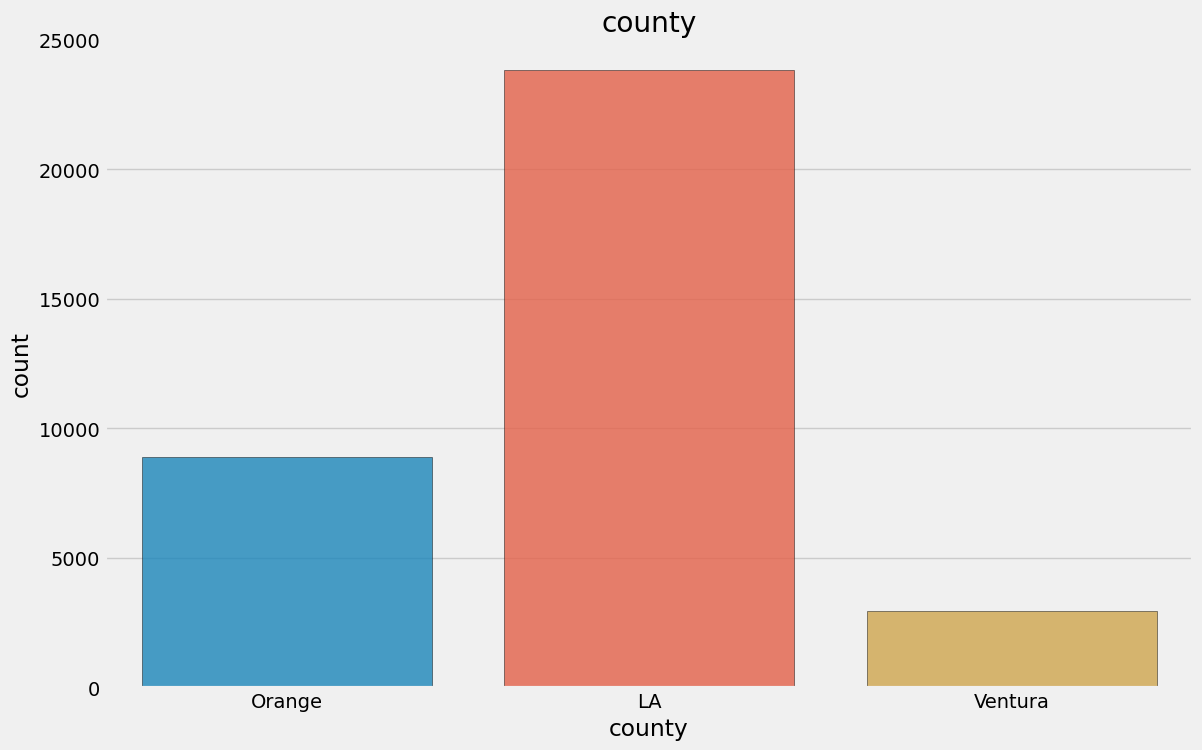

-------------------------------------------------------------


In [11]:
# Function to loop through desired df and respective columns to visualize 
w.check_cat_distribution(cat_cols)

<Axes: xlabel='tax_value', ylabel='Count'>

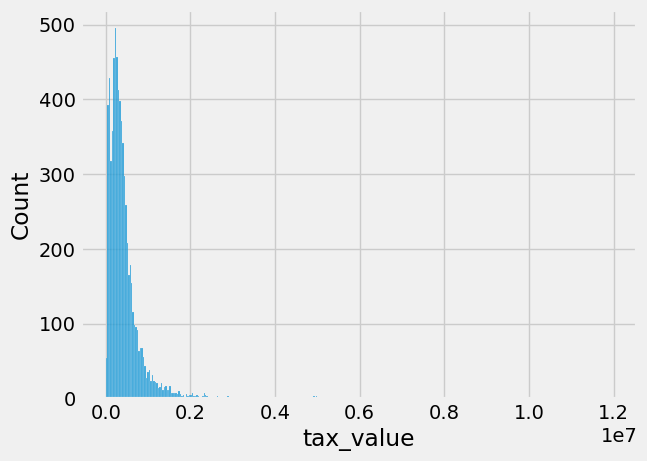

In [45]:
sns.histplot(data=train.sample(7000),x='tax_value')

In [12]:
# Observed irregular distributions in phone_service so conducting
# statistical analysis on churn x phone_service

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between churn & phone service\
Null $H_a$: There *is* an association between churn & phone service

In [13]:
#m. chi2_test(train['churn'],train['phone_service'])

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between churn & senior citizens\
Null $H_a$: There *is* an association between churn & senior citizens

In [14]:
#m.chi2_test(train['churn'],train['senior_citizen'])

## Explore: Continious Distributions

In [15]:
# compiling continious columns
num_cols = train[num_cols]

In [16]:
# Loop through respective df and column
#w.check_num_distribution(num_cols.sample(500),dataset=train)

#### A negative correlation between tenure and churn can be observed

## Explore: Correlations with Similar Data

In [17]:
zillow.head()

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county,la,orange,ventura
4,4,2.0,3633,296425,2005,LA,1,0,0
6,3,4.0,1620,847770,2011,LA,1,0,0
7,3,2.0,2077,646760,1926,LA,1,0,0
11,0,0.0,1200,5328,1972,LA,1,0,0
14,0,0.0,171,6920,1973,LA,1,0,0


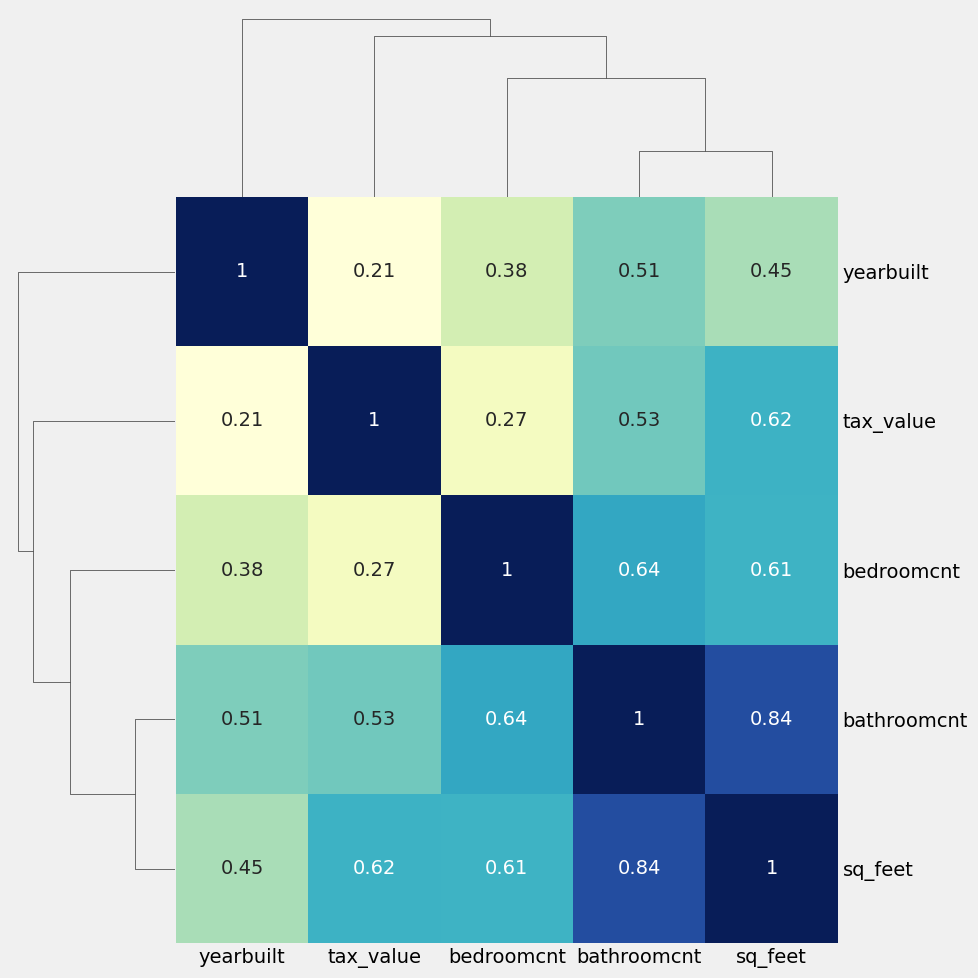

In [18]:
# Clustering correlation grid comparison

# Exploring binary categorical data as well as our two continious values -- total_charges & monthly_charges
zillow_grid = train[['tax_value','bedroomcnt','bathroomcnt','sq_feet','yearbuilt']]
sns_plot = sns.clustermap(zillow_grid.corr(),cmap = 'YlGnBu',annot=True)
sns_plot.cax.set_visible(False)
plt.show()

## Correlation grids help strengthen previous hunches and allow for a better assessment on feature testing
- ### Slight correlation between churn_binary and payment_type_electronic_check
- ### Stronger correlation between churn_binary and contract_type_month_to_month
- ### Negative correlation between churn_binary and tenure
- ### Slight correlation between churn_binary and monthly_charges
- ### Slight correlation between churn_binary and internet_service_type_fiber_optic

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & having a *month-to-month contract*\
Null $H_a$: There *is* an association between *churn* & having a *month-to-month contract*

In [19]:
# conduct statistical analysis of churn x contract_type_month_to_month
#m.chi2_test(train['churn_binary'],train['contract_type_month_to_month'])

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & *payment_type_electronic_check*\
Null $H_a$: There *is* an association between *churn* & *payment_type_electronic_check*

In [20]:
#m.chi2_test(train['churn_binary'],train['payment_type_electronic_check'])

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & *internet_service_type_fiber_optic*\
Null $H_a$: There *is* an association between *churn* & *internet_service_type_fiber_optic*

In [21]:
#m.chi2_test(train['churn_binary'],train['internet_service_type_fiber_optic'])

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & *monthly_charges*\
Null $H_a$: There *is* an association between *churn* & *monthly_charges*

In [22]:
# train.groupby('churn')['monthly_charges'].mean()

# monthly_churned = train[train.churn == 'Yes']['monthly_charges']
# monthly_nochurn = train[train.churn == 'No']['monthly_charges']


In [23]:
# # Set alpha
# α = .05
# # Assuming equal variance
# t_stat, p = stats.ttest_ind(monthly_churned,monthly_nochurn,equal_var=True)
# p

# m.check_p(p)

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & *tenure*\
Null $H_a$: There *is* an association between *churn* & *tenure*

In [24]:
# tenure_churned = train[train.churn == 'Yes']['tenure']
# tenure_nochurn = train[train.churn == 'No']['tenure']

In [25]:
# # Set alpha
# α = .05
# # Assuming equal variance
# t_stat, p = stats.ttest_ind(tenure_churned,tenure_nochurn,equal_var=True)
# p

# m.check_p(p)

# Modeling

## Features Selected
___
- continious - monthly_charges
- continious - tenure
- categorical - contract_type_month_to_month
- categorical - payment_type_electronic_check
- categorical - internet_service_type_fiber_optic
- categorical - senior_citizen_binary

## Determining Baseline

In [26]:
train.head()

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county,la,orange,ventura
41368,5,2.5,3204,692400,1976,Orange,0,1,0
8516,4,2.0,1446,239700,1964,Orange,0,1,0
44247,4,3.0,1491,246284,1936,LA,1,0,0
54283,4,3.0,2050,741132,1966,Ventura,0,0,1
2016,4,2.0,1874,554000,1966,LA,1,0,0


In [27]:
x_train = train[['bedroomcnt','bathroomcnt','sq_feet','yearbuilt','la','orange','ventura']]
y_train = train['tax_value']

x_validate = validate[['bedroomcnt','bathroomcnt','sq_feet','yearbuilt','la','orange','ventura']]
y_validate = validate['tax_value']

x_test = test[['bedroomcnt','bathroomcnt','sq_feet','yearbuilt','la','orange','ventura']]
y_test = test['tax_value']

In [28]:
# Set baseline & array for baseline predictions
baseline, baseline_array = m.find_baseline(train, y_train)

In [29]:
RMSE, R2 = m.regression_metrics(y_train, baseline_array)

In [30]:
metrics_df = m.metrics_dataframe(model='baseline', RMSE=RMSE, R2=R2)

## Scale

In [31]:
x_train_scaled, x_validate_scaled, x_test_scaled = w.QuickScale(x_train, x_validate, x_test, linear=True, scaler='MinMax')

## Finding Best Features

In [32]:
best_features = m.rfe(x_train, y_train, model='ols',k=6)
best_features

['bedroomcnt', 'bathroomcnt', 'yearbuilt', 'la', 'orange', 'ventura']

In [33]:
k_features = m.select_kbest(x_train, y_train, k=6)
k_features

['bedroomcnt', 'bathroomcnt', 'sq_feet', 'yearbuilt', 'la', 'orange']

## Model 1: OLS - Ordinary Least Squares

In [39]:
m.OLS(x_train, y_train, x_validate)

RMSE: 483825.58115944196
R2: 0.4069786842569785
Intercept: 4924732.9223620845
Coefficient: -127083.76834311901


(array([807147.65145518, 189234.03424187, 352249.8245754 , ...,
        279316.19078493, 619387.61893216, 820762.4099125 ]),
 array([ 77480.50647273, 822973.39137573, 535943.81772043, ...,
        314189.00074829, 719743.94225304, 308935.5010458 ]))

In [35]:
ols_rmse = 483825.58115944196
ols_r2 = 0.4069786842569785

In [36]:
m.save_metrics(df=metrics_df,model='ols',RMSE=ols_rmse,R2=ols_r2)

,model,rmse,r2
0,baseline,628280.636323,0.000000
1,ols,483825.581159,0.406979
